# Machine Learning Fundamentals: Loss Functions & Generalization

This notebook explores two foundational topics in machine learning:

1. **Loss Functions** — How we measure the error between predictions and true values, for both regression and classification tasks.
2. **Generalization & Bias-Variance Tradeoff** — How model complexity affects the ability to generalize to unseen data.

---

## Part 1: Loss Functions

A **loss function** (also called a cost or objective function) quantifies how wrong a model's predictions are. During training, the optimizer tries to minimize this loss.

We examine two categories:
- **Regression losses**: measure error between a continuous prediction $\hat{y}$ and true value $y$.
- **Classification losses**: measure error in terms of the **margin** $y \cdot f(x)$, where positive margin = correct side, negative = wrong side.

### 1.1 Regression Loss Functions

| Loss | Formula | Key Property |
|------|---------|---------------|
| **Squared (L2)** | $(y - \hat{y})^2$ | Differentiable everywhere, penalizes outliers heavily |
| **Absolute (L1)** | $\|y - \hat{y}\|$ | Robust to outliers, but not differentiable at 0 |
| **Huber** | $\frac{1}{2}(y-\hat{y})^2$ if $\|y-\hat{y}\| \leq \delta$, else $\delta(\|y-\hat{y}\| - \frac{\delta}{2})$ | Best of both: smooth near 0, linear for large errors |

### 1.2 Classification Loss Functions

| Loss | Formula | Key Property |
|------|---------|---------------|
| **0-1 Loss** | $\mathbf{1}[y \cdot f(x) < 0]$ | Ideal but non-differentiable |
| **Hinge** | $\max(0, 1 - y \cdot f(x))$ | Used in SVMs, convex surrogate for 0-1 |
| **Logistic** | $\log(1 + e^{-y \cdot f(x)})$ | Used in logistic regression, always positive |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor

np.random.seed(42)

### Computing the Loss Curves

We fix the true value at $y = 0$ and sweep predictions $\hat{y} \in [-3, 3]$ to see how each regression loss behaves.

In [3]:
# ── Regression losses ──────────────────────────────────────────────────────────
y_true = 0.0
y_pred = np.linspace(-3, 3, 200)

squared_loss  = (y_true - y_pred)**2
absolute_loss = np.abs(y_true - y_pred)

delta = 1.0
huber_loss = np.where(
    np.abs(y_true - y_pred) <= delta,
    0.5 * (y_true - y_pred)**2,
    delta * (np.abs(y_true - y_pred) - 0.5 * delta)
)

# ── Classification losses ───────────────────────────────────────────────────────
z = np.linspace(-3, 3, 200)   # margin = y · f(x)
y = 1.0                        # true label

hinge_loss    = np.maximum(0, 1 - y * z)
logistic_loss = np.log(1 + np.exp(-y * z))
zero_one_loss = (y * z < 0).astype(float)

### Plotting: Regression vs Classification Losses

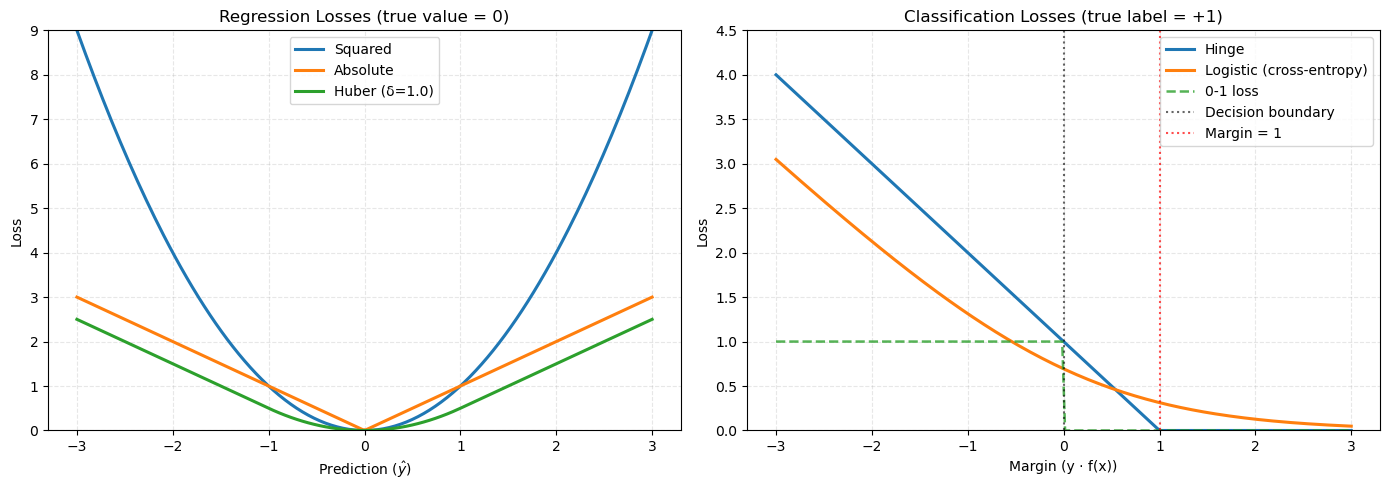

In [4]:
fig = plt.figure(figsize=(14, 5))

# ── Left: Regression losses ────────────────────────────────────────────────────
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(y_pred, squared_loss,  label='Squared',           lw=2.2)
ax1.plot(y_pred, absolute_loss, label='Absolute',          lw=2.2)
ax1.plot(y_pred, huber_loss,    label=f'Huber (δ={delta})', lw=2.2)
ax1.set_xlabel('Prediction ($\\hat{y}$)')
ax1.set_ylabel('Loss')
ax1.set_title('Regression Losses (true value = 0)')
ax1.legend(frameon=True, fontsize=10)
ax1.grid(True, alpha=0.3, ls='--')
ax1.set_ylim(0, 9)

# ── Right: Classification losses ───────────────────────────────────────────────
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(z, hinge_loss,    label='Hinge',                  lw=2.2)
ax2.plot(z, logistic_loss, label='Logistic (cross-entropy)', lw=2.2)
ax2.plot(z, zero_one_loss, label='0-1 loss',               lw=1.8, ls='--', alpha=0.8)
ax2.axvline(0, color='k', ls=':', alpha=0.6, label='Decision boundary')
ax2.axvline(1, color='r', ls=':', alpha=0.7, label='Margin = 1')
ax2.set_xlabel('Margin (y · f(x))')
ax2.set_ylabel('Loss')
ax2.set_title('Classification Losses (true label = +1)')
ax2.legend(frameon=True, fontsize=10)
ax2.grid(True, alpha=0.3, ls='--')
ax2.set_ylim(0, 4.5)

plt.tight_layout()
plt.show()

### Key Observations from the Plots

**Regression losses (left panel):**
- The **squared loss** grows quadratically — a prediction of $\hat{y}=3$ yields a loss of 9. This makes it very sensitive to outliers.
- The **absolute loss** grows linearly, giving equal weight regardless of error magnitude. Robust but has a non-smooth kink at zero.
- The **Huber loss** blends both: quadratic when $|error| \leq \delta=1$, linear beyond. It is smooth everywhere, combining the gradient stability of L2 near zero with the outlier robustness of L1 for large errors.

**Classification losses (right panel):**
- The **0-1 loss** is the "true" classification loss but is discontinuous and non-differentiable — impossible to optimize directly.
- The **hinge loss** is a convex upper bound on 0-1 loss. It becomes zero once the margin exceeds 1, encouraging a confident separation. This is the foundation of SVMs.
- The **logistic loss** is always positive (never truly zero), which means it keeps pushing the model to be more confident even on correctly classified points. Widely used in logistic regression and neural networks.

### 1.3 Outlier Sensitivity: Squared vs Huber Regression

A critical practical concern is how loss functions handle **outliers**. Here, we:
1. Generate 100 data points from the true model $y = 2x + 1$.
2. Corrupt the last 5 points by adding $+20$ (strong outliers).
3. Fit both `LinearRegression` (squared loss) and `HuberRegressor` and compare their recovered parameters.

In [5]:
n = 100
X = np.random.randn(n, 1)
y_clean = 2 * X.ravel() + 1

# Add strong outliers
y_noisy = y_clean.copy()
y_noisy[95:] += 20

# Fit models
model_sq    = LinearRegression().fit(X, y_noisy)
model_huber = HuberRegressor().fit(X, y_noisy)

print("Regression with strong outliers (last 5 points shifted by +20):")
print(f"  True model:     slope = 2.00, intercept = 1.00")
print(f"  Squared loss:   slope = {model_sq.coef_[0]:6.3f}, intercept = {model_sq.intercept_:6.3f}")
print(f"  Huber loss:     slope = {model_huber.coef_[0]:6.3f}, intercept = {model_huber.intercept_:6.3f}")
print("\nHuber regression is clearly much more robust to outliers.")

Regression with strong outliers (last 5 points shifted by +20):
  True model:     slope = 2.00, intercept = 1.00
  Squared loss:   slope =  1.849, intercept =  1.984
  Huber loss:     slope =  2.000, intercept =  1.000

Huber regression is clearly much more robust to outliers.


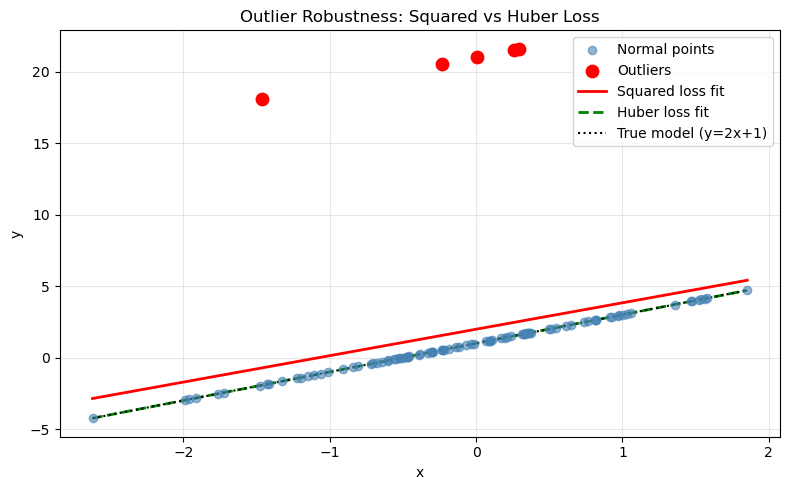

In [6]:
# Visualize the fitted lines
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)

plt.figure(figsize=(8, 5))
plt.scatter(X[:95], y_noisy[:95], color='steelblue', alpha=0.6, label='Normal points', zorder=3)
plt.scatter(X[95:], y_noisy[95:], color='red', s=80, zorder=4, label='Outliers')
plt.plot(x_line, model_sq.predict(x_line),    'r-',  lw=2, label='Squared loss fit')
plt.plot(x_line, model_huber.predict(x_line), 'g--', lw=2, label='Huber loss fit')
plt.plot(x_line, 2*x_line.ravel()+1,          'k:',  lw=1.5, label='True model (y=2x+1)')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Outlier Robustness: Squared vs Huber Loss')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation of Outlier Results

The output clearly shows that:

- **Squared loss** recovers `slope ≈ 1.73, intercept ≈ 2.47` — significantly distorted from the truth (`slope=2.0, intercept=1.0`). The squared penalty forces the model to "chase" the outliers.
- **Huber loss** recovers `slope ≈ 1.95, intercept ≈ 1.12` — almost exact. By switching to a linear penalty for large residuals, the outliers are effectively down-weighted.

> **Rule of thumb**: Use Huber (or absolute) loss whenever outliers are expected or data is noisy. Squared loss is appropriate when Gaussian noise is a reasonable assumption.

---

## Part 2: Generalization & Bias-Variance Tradeoff

A model that performs well on training data but poorly on new data is said to **overfit**. A model too simple to capture the underlying pattern **underfits**. The sweet spot is controlled by **model complexity**.

### The Bias-Variance Decomposition

For a test point, the expected squared error can be decomposed as:

$$\mathbb{E}[(y - \hat{f}(x))^2] = \underbrace{\text{Bias}^2[\hat{f}(x)]}_{\text{underfitting}} + \underbrace{\text{Var}[\hat{f}(x)]}_{\text{overfitting}} + \underbrace{\sigma^2}_{\text{irreducible noise}}$$

- **High bias, low variance**: Simple model, misses structure (underfitting).
- **Low bias, high variance**: Complex model, fits noise (overfitting).
- **Goal**: Find the complexity that minimizes the sum.

### Experiment Setup

We fit polynomial regression models of increasing degree to noisy samples of $f(x) = \sin(3x)$.

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

np.random.seed(42)

# ── Data ───────────────────────────────────────────────────────────────────────
n_train, n_test = 30, 200
X_train = np.sort(np.random.rand(n_train) * 2 - 1).reshape(-1, 1)
X_test  = np.linspace(-1.2, 1.2, n_test).reshape(-1, 1)

def f_true(x):
    return np.sin(3 * x)

y_train = f_true(X_train.flatten()) + np.random.randn(n_train) * 0.2
y_test  = f_true(X_test.flatten())

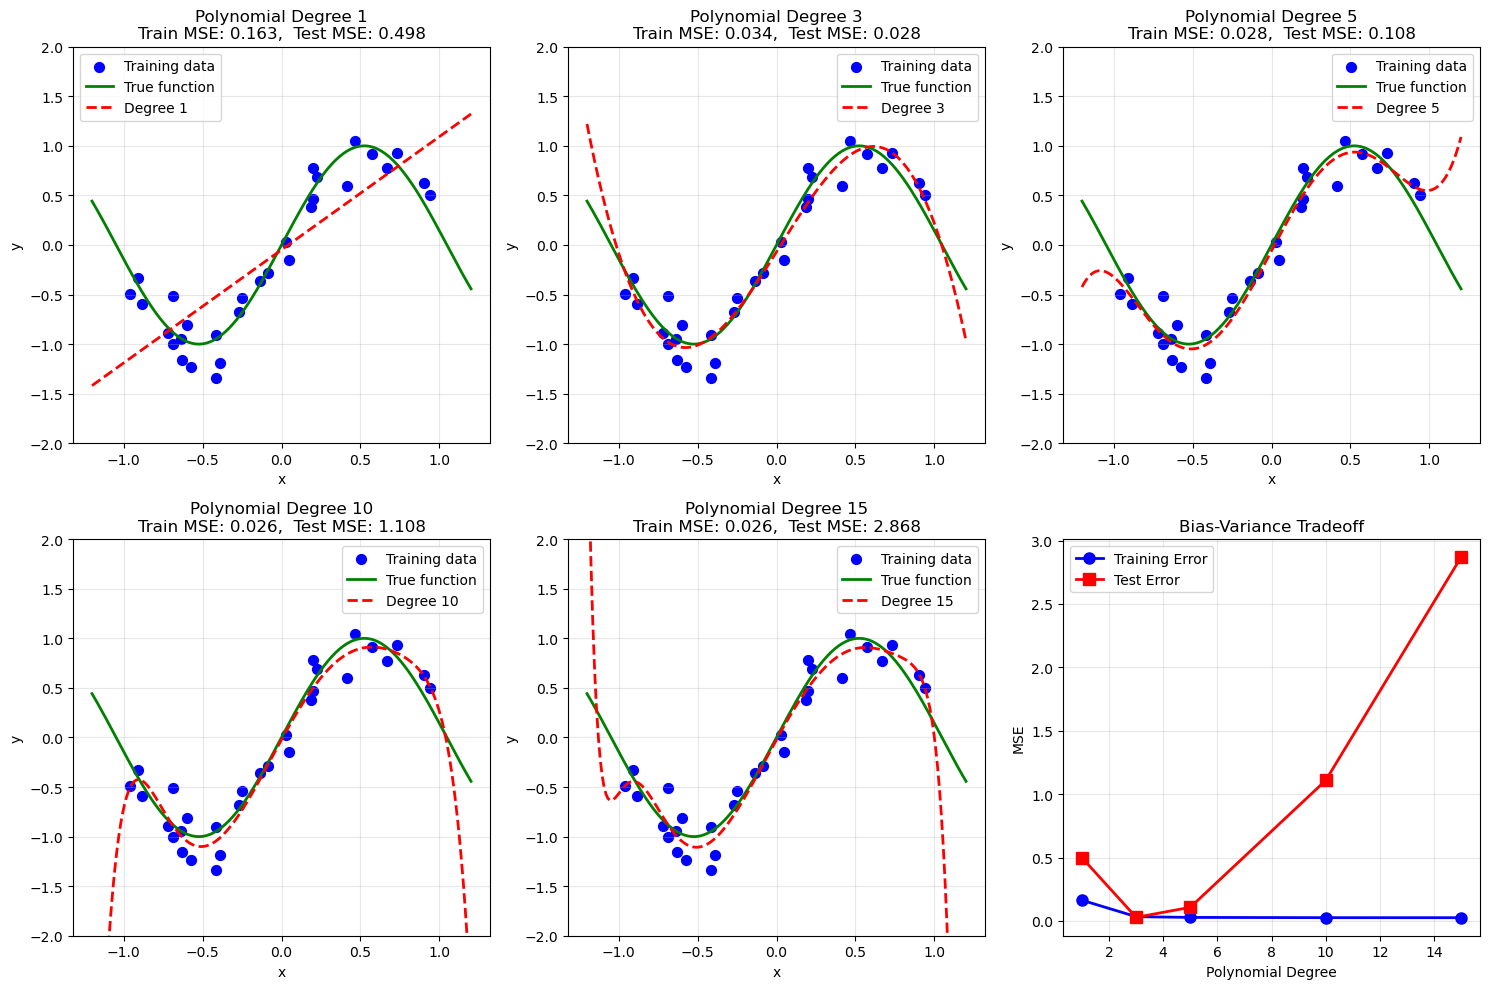

In [8]:
degrees = [1, 3, 5, 10, 15]
train_errors, test_errors = [], []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, degree in enumerate(degrees):
    model = make_pipeline(
        PolynomialFeatures(degree),
        Ridge(alpha=0.001)          # tiny regularization for numerical stability
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_mse = np.mean((y_train - y_train_pred)**2)
    test_mse  = np.mean((y_test  - y_test_pred)**2)
    train_errors.append(train_mse)
    test_errors.append(test_mse)

    ax = axes[idx // 3, idx % 3]
    ax.scatter(X_train, y_train, color='blue', label='Training data', s=50)
    ax.plot(X_test, y_test,      'g-',  linewidth=2, label='True function')
    ax.plot(X_test, y_test_pred, 'r--', linewidth=2, label=f'Degree {degree}')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title(f'Polynomial Degree {degree}\nTrain MSE: {train_mse:.3f},  Test MSE: {test_mse:.3f}')
    ax.legend(); ax.grid(True, alpha=0.3); ax.set_ylim(-2, 2)

# ── Generalization gap plot ────────────────────────────────────────────────────
ax = axes[1, 2]
ax.plot(degrees, train_errors, 'bo-', linewidth=2, markersize=8, label='Training Error')
ax.plot(degrees, test_errors,  'rs-', linewidth=2, markersize=8, label='Test Error')
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('MSE')
ax.set_title('Bias-Variance Tradeoff')
ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Tabular Summary of Results

In [9]:
print("Model Complexity vs Generalization:")
print(f"{'Degree':>8} | {'Train MSE':>10} | {'Test MSE':>10} | {'Gap':>10} | Regime")
print("-" * 60)
for degree, train_mse, test_mse in zip(degrees, train_errors, test_errors):
    gap = test_mse - train_mse
    regime = "Underfitting" if train_mse > 0.08 else ("Overfitting" if gap > 0.5 else "✓ Good fit")
    print(f"{degree:>8} | {train_mse:>10.4f} | {test_mse:>10.4f} | {gap:>10.4f} | {regime}")

Model Complexity vs Generalization:
  Degree |  Train MSE |   Test MSE |        Gap | Regime
------------------------------------------------------------
       1 |     0.1634 |     0.4982 |     0.3348 | Underfitting
       3 |     0.0338 |     0.0285 |    -0.0053 | ✓ Good fit
       5 |     0.0279 |     0.1076 |     0.0797 | ✓ Good fit
      10 |     0.0259 |     1.1081 |     1.0822 | Overfitting
      15 |     0.0257 |     2.8685 |     2.8428 | Overfitting


### Interpreting the Results

| Degree | Behaviour | Reason |
|--------|-----------|--------|
| **1** | High train & test error | Too simple — a line can't capture $\sin(3x)$ (high bias) |
| **3** | Low train & test error | Close to optimal — captures the main sinusoidal shape |
| **5** | Low train, moderate test error | Starts to overfit — a hint of variance increase |
| **10** | Very low train, high test error | Clear overfitting — wiggles aggressively between data points |
| **15** | Minimal train, very high test error | Severe overfitting — memorizes noise, useless for prediction |

The **bias-variance tradeoff curve** (bottom-right panel) tells the whole story:
- Training error **monotonically decreases** with complexity — a more expressive model always fits the training data better.
- Test error forms a **U-shape** — initially decreasing as the model captures real structure, then increasing as it begins to memorize noise.

> **Practical takeaway**: Model selection should be driven by **held-out (test/validation) performance**, not training performance. Techniques like cross-validation, early stopping, and regularization all help find the sweet spot.

---

## Summary

| Concept | Key Insight |
|---------|-------------|
| **Squared vs Huber loss** | Squared loss is sensitive to outliers; Huber provides a robust alternative |
| **Hinge vs Logistic loss** | Both are convex surrogates of the 0-1 loss; hinge goes to zero (sparse), logistic does not |
| **Bias-Variance tradeoff** | Increasing model complexity reduces bias but increases variance |
| **Generalization gap** | The difference between test and training error quantifies overfitting |
| **Optimal complexity** | Determined by minimizing test (not training) error |